# Automatic Classification of Sharepoint Documents based on their Titles

University of Bern / CAS Applied data Science Projet Module 3 / Alfonso Garcia-Miguel and Lionel Perret

# Table of Content
1. Overview of the Project
2. Load the necessary packages and define the necessary functions
3. Load the dataset into tf.keras
4. Prepare the text data - Text Vectorization
5. Train and optimize the 2 models
6. Results and Comparison
7. References and Detailed explaination

# 1. Overview of the Project



<img src="./Overview.jpg" alt="Drawing" style="width: 1000px;">

This project aims at automating the classification of documents based on the title. The possible classes correspond to four different departments of an organisation. Using supervised learning from a dataset containing more than 185.000 labelled documents, with title and department, we train the machine so that, given a textual input (the title of the document) we obtain the corresponding department that this document belongs to.
As it is common in machine learning projects, the first step involves some data cleaning (selecting the appropriate features of the dataset, removing special characters...). For this particular project, we decided to include the file extension as part of the title, since this information might affect the end result.

# 2 Load the necessary packages and define the necessary functions

In [2]:
import pandas as pd
import os

import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import matplotlib.pyplot as plt

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

from tensorflow import keras

In [3]:
import mlflow
import mlflow.keras

from mlflow import log_metric, log_param, log_artifacts
mlflow.set_experiment("Classification")

mlflow.tensorflow.autolog()    
#mlflow.keras.autolog()

In [4]:
# Plot Function that takes a History object as input variable and the name of the metric to be plotted
def plot_graphs(history, metric):
  plt.plot(history.history[metric])              # history.history attribute is a record of training/validation- 
  plt.plot(history.history['val_'+metric], '')   # Loss values and metrics values at sucessive epochs
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# 3. Load the dataset into tf.keras

## 3.1 Convert the dataset into a file structure that can be read by tf.keras.preprocessing

In [5]:
# load the dataset for our M3 Project
df = pd.read_csv('CleanTitle.csv', usecols=[1,2,3], encoding='utf-8')
df

,Name,File_type,Service
0,200903 07 PfR21 HQ Budget Decelerate Inp...,ppt,FAD
1,FTE Control DP xls,xls,FAD
2,2020 09 03 ICRC Letter re IRS Correspondence w...,pdf,FAD
3,supporting organizations practice guide pdf,pdf,FAD
4,2019 06 19 PWS JEH FL Bar Tax intl charitable ...,pdf,FAD
...,...,...,...
185723,Test pg 0 pdf,pdf,PROT
185724,Full test negotiation pdf,pdf,PROT
185725,Gaza PCPiE LL Pres 24 11 2017 EGY ppt,ppt,PROT
185726,ECS PCP CoH EWPA+Ben ppt,ppt,PROT


In [6]:
# Define the path of the directory where all the files will be stored
files_dir = './../../Title-Files'

In [7]:
 # Check whether the specified path is already present or not  
if os.path.isdir(files_dir):
    print("Directory " +files_dir +" already exist")
else:
    print("Directory " +files_dir +" will be created")
    os.mkdir(files_dir) # Create the root directory
    os.mkdir(files_dir+'/FAD/') # Create the sub-directories
    os.mkdir(files_dir+'/REM/')
    os.mkdir(files_dir+'/PROT/')
    os.mkdir(files_dir+'/ASSIST/')
    
    df_FAD = df.loc[df['Service'].isin(['FAD'])] # Create a df with the "FAD" category
    # Create separate title-files within the "FAD" sub-directory
    i=0
    for index, row in df_FAD.iterrows():
        if i > len(df_FAD):
           break
        else:
           f = open(files_dir + '/FAD/' + str(i) + '.txt', 'w', encoding='utf-8')
           f.write(row[0])
           f.close()
           i+=1


    df_REM = df.loc[df['Service'].isin(['REM'])] # Create separate title-files within the "REM" sub-directory
    i=0
    for index, row in df_REM.iterrows():
        if i > len(df_REM):
           break
        else:
           f = open(files_dir + '/REM/'+ str(i) + '.txt', 'w', encoding='utf-8')
           f.write(row[0])
           f.close()
           i+=1


    df_PROT = df.loc[df['Service'].isin(['PROT'])] # Create separate title-files within the "PROT" sub-directory
    i=0
    for index, row in df_PROT.iterrows():
        if i > len(df_PROT):
           break
        else:
           f = open(files_dir + '/PROT/'+ str(i) + '.txt', 'w', encoding='utf-8')
           f.write(row[0])
           f.close()
           i+=1


    df_ASSIST = df.loc[df['Service'].isin(['ASSIST'])] # Create separate title-files within the "ASSIST" sub-directory
    i=0
    for index, row in df_ASSIST.iterrows():
        if i > len(df_ASSIST):
           break
        else:
           f = open(files_dir + '/ASSIST/'+ str(i) + '.txt', 'w', encoding='utf-8')
           f.write(row[0])
           f.close()
           i+=1

Directory ./../../Title-Files already exist


## 3.2 Create the training and Validation data set
### 3.2.1 Considerations about data sets:

The usual industry standard when splitting datasets is to create three different datasets:
- Training: the dataset that will train the machine. This is the first split
- Validation: a dataset not seen before by the computer, to check the accuracy of the training, assess overfitting, etc. This set will serve to see how good is our model. However, the model is modified several times (learning rate, layers...) to reach maximum efficiency
- Test: A dataset used to provide an unbiased evaluation of a final model fit on the training dataset. This one is used to be sure that our model is good in general, and not only for the Validation Dataset. 

However, in testing projects or academia, and for models that will not be paid for, it is usual to use only two datasets. This is the approach chosen for our project

In [8]:
# Define the batch size and the seed
batch_size = 32
seed = 42

In [9]:
# Training data set: "raw_train_ds" is a "tf.data.Dataset" object
raw_train_ds = preprocessing.text_dataset_from_directory(
    files_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# Check which label correspond to which number
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Found 183320 files belonging to 4 classes.
Using 146656 files for training.
Label 0 corresponds to ASSIST
Label 1 corresponds to FAD
Label 2 corresponds to PROT
Label 3 corresponds to REM


In [10]:
# Validation data set: "raw_val_ds" is a "tf.data.Dataset" object
raw_val_ds = preprocessing.text_dataset_from_directory(
    files_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 183320 files belonging to 4 classes.
Using 36664 files for validation.


 Number of titles for each department/class (Total 183'320 Titles):
 - "ASSIT" Department :  24'604 Titles
 - "FAD" Department:     85'122 Titles
 - "PROT" Department:    44'794 Titles
 - "REM" Document:       28'800 Titles
 
 Note: We have also done tests with the same number of title per department/class and we get similar results

# 4. Prepare the text data - Text Vectorization
"TextVectorization" : transforms a batch of strings into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens)
https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

The processing of each sample contains the following steps:

- standardize each sample (usually lowercasing + punctuation stripping)
- split each sample into substrings (usually words)
- recombine substrings into tokens (usually ngrams)
- index tokens (associate a unique int value with each token)
- transform each sample using this index, either into a vector of ints or a dense float vector

Then, we use two modes:
## Binary Text Vectorization
returns an array denoting which tokens (words) exist at least once in the input. 
## Integer Text Vectorization
replaces each token by an integer, respecting their order.




This can be seen with the `print` command below.

In [11]:
VOCAB_SIZE = 10000

In [12]:
# TextVectorization is used with "binary" output_mode:
# The output is a single array per batch, with a size of VOCAB_SIZE
# This array contains 1s in all elements where the token mapped to that index exist at least once in the batch item
binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

### output_mode: 

Optional specification for the output of the layer. Values can be "int", "binary", "count" or "tf-idf", configuring the layer as follows: "int": Outputs integer indices, one integer index per split string token. When output == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens-2 instead of max_tokens-1 "binary": Outputs a single int array per batch, of either vocab_size or max_tokens size, containing 1s in all elements where the token mapped to that index exists at least once in the batch item. "count": As "binary", but the int array contains a count of the number of times the token at that index appeared in the batch item. "tf-idf": As "binary", but the TF-IDF algorithm is applied to find the value in each token slot.

### output_sequence_length:

Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape [batch_size, output_sequence_length] regardless of how many tokens resulted from the splitting step. Defaults to None.

In [13]:
# TextVectorization is used with "INT" output_mode:
# The output is an array with integer indices, one integer index per split string token.
# The output sequence is truncated to MAX_SEQUENCE_LENGTH, regardless of how many token resulted from the splitting step
MAX_SEQUENCE_LENGTH = 25

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

### Turning strings into numerical values:

Using a text-only dataset (without the labels), we use the adapt function to build an index of strings to integers.

In [14]:
# Make a text-only dataset (without labels)
# "adapt" is used to fit the state of the preprocessing layer to the dataset.
# This will cause the model to build an index of strings to integers.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [15]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [16]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [17]:
# Retrieve a batch (of 32 titles and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_title, first_label = text_batch[0], label_batch[0]
print("Document Title:", first_title)
print("Label:", first_label)

Document Title: tf.Tensor(b'CICR logo gif', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


In [18]:
print("'binary' vectorized Document Title:")
print(binary_vectorize_text(first_title, first_label)[0])

'binary' vectorized Document Title:
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [19]:
print("'int' vectorized Document Title:",
      int_vectorize_text(first_title, first_label)[0])

'int' vectorized Document Title: tf.Tensor(
[[  53 1076   37    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 25), dtype=int64)


### finalizing the preparation of the dataset
As the final step, we apply the `TextVectorization` function we defined above to the train and validation datasets:

In [20]:
# Train and Validation Data Set with the Binary Vectorization
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)

# Train and Validation Data Set with the INT Vectorization
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)

# 5. Train and optimize the 2 models

## Taking care of performance:
Since the volume of our dataset is quite big, we use two methods to optimize the performance of the machine:
- `cache()` keeps data in memory after it is taken from the disk. This ensures that our data is not a bottleneck that slows the whole process.
- `prefetch()` overlaps data preprocessing and model execution while training the model.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

We apply the function above to our training and validation datasets.

In [22]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)

## Model A / Binary Vectorization - Linear Model
We now create our neural network. For the binary vectorized data, we train a simple bag-of-words linear model:

In [24]:
binary_model = tf.keras.Sequential([layers.Dense(4, activation='softmax')])

binary_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

history = binary_model.fit(
    binary_train_ds,
    validation_data=binary_val_ds,
    epochs=10)

2021/03/10 22:12:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.


Epoch 1/10
4583/4583 [==============================] - 1225s 267ms/step - loss: 0.8866 - accuracy: 0.6858 - val_loss: 0.5217 - val_accuracy: 0.8307
Epoch 2/10
4583/4583 [==============================] - 32s 7ms/step - loss: 0.4706 - accuracy: 0.8504 - val_loss: 0.4206 - val_accuracy: 0.8600
Epoch 3/10
4583/4583 [==============================] - 26s 6ms/step - loss: 0.3818 - accuracy: 0.8764 - val_loss: 0.3796 - val_accuracy: 0.8708
Epoch 4/10
4583/4583 [==============================] - 25s 5ms/step - loss: 0.3399 - accuracy: 0.8870 - val_loss: 0.3581 - val_accuracy: 0.8758
Epoch 5/10
4583/4583 [==============================] - 44s 10ms/step - loss: 0.3149 - accuracy: 0.8929 - val_loss: 0.3452 - val_accuracy: 0.8791
Epoch 6/10
4583/4583 [==============================] - 25s 5ms/step - loss: 0.2981 - accuracy: 0.8976 - val_loss: 0.3371 - val_accuracy: 0.8824
Epoch 7/10
4583/4583 [==============================] - 27s 6ms/step - loss: 0.2858 - accuracy: 0.9011 - val_loss: 0.3317 - v

2021/03/10 22:36:49 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:794: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"
2021/03/10 22:36:49 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:597: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"


(0.0, 0.7288983017206192)

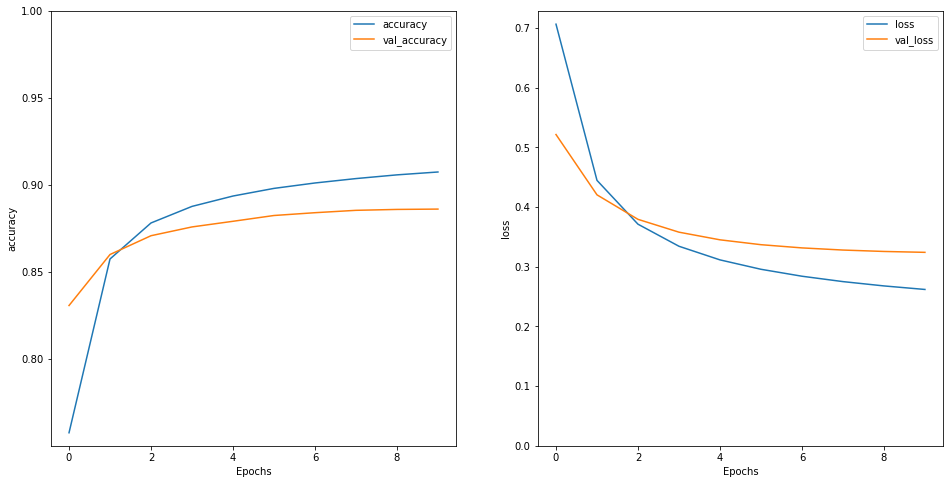

In [25]:
#Plot
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

#### The results is quite good, almost 90% val_accuracy, lets see how our second model does with same learning rate and same number of Epoch

## Model B / Integer Vectorization - CNN model
We use a neural network with 4 layers, please refer to architecture detailed explanation at the end of this notebook
<img src="https://miro.medium.com/max/1236/1*BEaZkpZJ4mFR-i2U4VOXsA.png" width="800">
#### 1: Embedding Layer 
Takes as input integer encoded text and initializes random or pre-trained word embedding weights 
#### 2: Convolutional Layer
Takes the texts transformed to sequences of word embeddings as input and creates feature vectors by analysing the word embeddings for each text
#### 3: Global Max Pooling Layer
Takes the variable-length feature vectors of the convolutional layer as input, and creates fixed-length vectors out of them. By creating these fixed-length feature vectors, the less-relevant local information is removed.
#### 4: Fully-Connected Dense Layer with Softmax
Takes the fixed-length feature vectors as input and provide as output numerical values for each class. Softmax provides predicted probabilies for each class

In [26]:
# vocab_size is VOCAB_SIZE + 1 since 0 is used additionally for padding.
int_model =  tf.keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE + 1,
                     output_dim=64,
                     mask_zero=True), # input value 0: special "padding" value - masked out
    layers.Conv1D(filters=64, kernel_size=5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(4, activation='softmax')
])

int_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

2021/03/10 22:36:50 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:780: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"


Epoch 1/10
4583/4583 [==============================] - 1190s 259ms/step - loss: 0.5475 - accuracy: 0.7903 - val_loss: 0.2910 - val_accuracy: 0.8979
Epoch 2/10
4583/4583 [==============================] - 44s 10ms/step - loss: 0.2368 - accuracy: 0.9183 - val_loss: 0.2848 - val_accuracy: 0.9045
Epoch 3/10
4583/4583 [==============================] - 44s 10ms/step - loss: 0.1767 - accuracy: 0.9405 - val_loss: 0.3043 - val_accuracy: 0.9035
Epoch 4/10
4583/4583 [==============================] - 44s 10ms/step - loss: 0.1368 - accuracy: 0.9546 - val_loss: 0.3375 - val_accuracy: 0.9016
Epoch 5/10
4583/4583 [==============================] - 45s 10ms/step - loss: 0.1089 - accuracy: 0.9647 - val_loss: 0.3811 - val_accuracy: 0.9017
Epoch 6/10
4583/4583 [==============================] - 45s 10ms/step - loss: 0.0898 - accuracy: 0.9706 - val_loss: 0.4276 - val_accuracy: 0.9009
Epoch 7/10
4583/4583 [==============================] - 45s 10ms/step - loss: 0.0770 - accuracy: 0.9758 - val_loss: 0.469

2021/03/10 23:03:48 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:794: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"
2021/03/10 23:03:48 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:597: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"


(0.0, 0.5934882761910558)

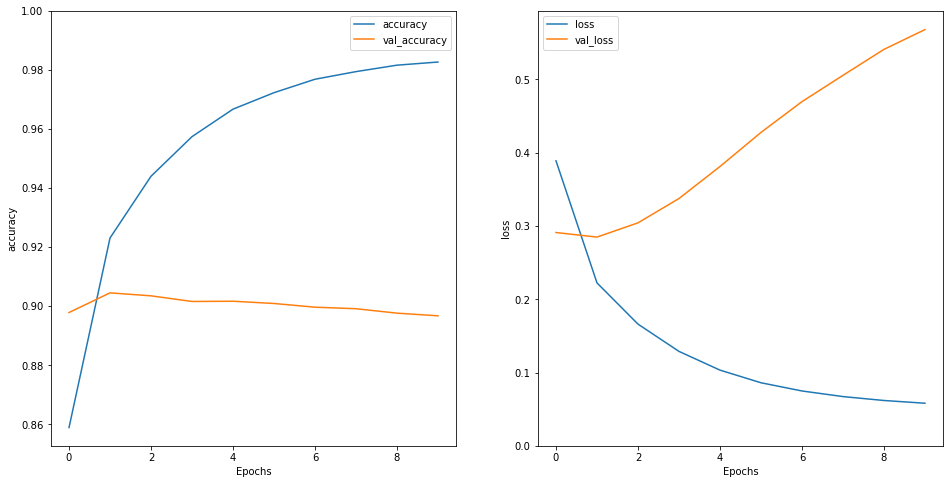

In [27]:
#Plot
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

#### We notice that the model is overfitting, as val_loss is increasing after Epoch 1, so let's try to change learning rate to 0.00005

In [28]:
# vocab_size is VOCAB_SIZE + 1 since 0 is used additionally for padding.
int_model =  tf.keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE + 1,
                     output_dim=64,
                     mask_zero=True), # input value 0: special "padding" value - masked out
    layers.Conv1D(filters=64, kernel_size=5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(4, activation='softmax')
])

int_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.00005),
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=10)

2021/03/10 23:03:49 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:770: UserWarning: Logging to MLflow failed: Changing param values is not allowed. Param with key='opt_learning_rate' was already logged with value='0.001' for run ID='45734f2cbf814968912becffe1fced2c'. Attempted logging new value '5e-05'."
2021/03/10 23:03:49 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:780: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"


Epoch 1/10
4583/4583 [==============================] - 59s 13ms/step - loss: 1.1417 - accuracy: 0.5213 - val_loss: 0.7403 - val_accuracy: 0.7234
Epoch 2/10
4583/4583 [==============================] - 52s 11ms/step - loss: 0.6419 - accuracy: 0.7698 - val_loss: 0.4704 - val_accuracy: 0.8403
Epoch 3/10
4583/4583 [==============================] - 46s 10ms/step - loss: 0.4202 - accuracy: 0.8604 - val_loss: 0.3812 - val_accuracy: 0.8695
Epoch 4/10
4583/4583 [==============================] - 40s 9ms/step - loss: 0.3370 - accuracy: 0.8859 - val_loss: 0.3439 - val_accuracy: 0.8813
Epoch 5/10
4583/4583 [==============================] - 41s 9ms/step - loss: 0.2941 - accuracy: 0.9002 - val_loss: 0.3244 - val_accuracy: 0.8877
Epoch 6/10
4583/4583 [==============================] - 40s 9ms/step - loss: 0.2670 - accuracy: 0.9087 - val_loss: 0.3132 - val_accuracy: 0.8911
Epoch 7/10
4583/4583 [==============================] - 40s 9ms/step - loss: 0.2477 - accuracy: 0.9148 - val_loss: 0.3064 - val

2021/03/10 23:11:09 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:794: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"
2021/03/10 23:11:09 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "C:\Users\lione\anaconda3\envs\TF\lib\site-packages\mlflow\tensorflow.py:597: UserWarning: Logging to MLflow failed: 'utf-8' codec can't decode byte 0xe9 in position 48: invalid continuation byte"


(0.0, 1.0259763874113559)

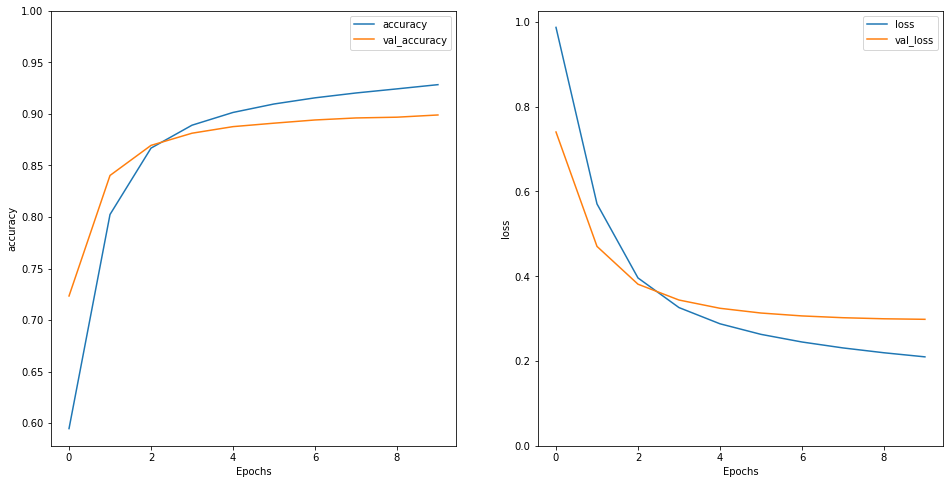

In [29]:
#Plot
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

#### With this change, we do not have overfitting anymore

# 6. Results - Models Comparison

## Viewing the results with ML Flow ****** NOT YET WORKING ******
After having imported MLFlow, and run the program, the tracking API writes data into files into a local directory. To view the result, we must run the user interface (mlflow ui) and view it at http://localhost:5000.  

In [30]:
!mlflow ui

## Model Comparison

In [31]:
print("Binary Vectorization - Bag of Word / Linear:")
print(binary_model.summary())

Binary Vectorization - Bag of Word / Linear:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 40004     
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
print("Integer Vectorizatin - ConvNet Model:")
print(int_model.summary())

Integer Vectorizatin - ConvNet Model:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640064    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#we compare the results of both models
binary_loss, binary_accuracy = binary_model.evaluate(binary_val_ds)
int_loss, int_accuracy = int_model.evaluate(int_val_ds)

print("Model A / Binary Vectorization - Linear Model - accuracy: {:2.2%}".format(binary_accuracy))
print("Model B / Integer Vectorization - CNN model - accuracy:    {:2.2%}".format(int_accuracy))

1146/1146 [==============================] - 2s 1ms/step - loss: 0.2984 - accuracy: 0.8990
Model A / Binary Vectorization - Linear Model - accuracy: 88.61%
Model B / Integer Vectorization - CNN model - accuracy:    89.90%


## Other Tests Done

### Tests with other optimizers

"SGD" - Gradient descent with momentum optimizer: about 15% less accuracy than achieved above

"RMSprop" - Root Mean Square propagation optimizer: about 4% less accuary than achieved above but MUCH FASTER


### Tests with same database, but without file type information

Without file type information: Accuracy was about 1% less than achieved above

# 7. References and Detailed explaination

## Convolutional Neural Network Architecture applied to Text Classification
Source: https://machine-learning-company.nl/en/technical/convolutional-neural-network-text-classification-with-risk-assessment-eng/

<img src="https://miro.medium.com/max/1236/1*BEaZkpZJ4mFR-i2U4VOXsA.png" width="800">
"Now, we are going to take a look at a specific CNN architecture, depicted in Figure 3. The CNN consists of different layers, which are connected to each other. The starting layer is the embedding layer, which takes integer encoded texts as input, and initializes random or pre-trained word embedding weights. The weights are learnt during training of the CNN by updating the weights in each epoch (an epoch is a full run through the network). In Figure 3, the word embeddings are shown for the words in the text “Green shirt for men regular fit”, where for illustration purposes the word embeddings are of dimension 5.

The next layer is the convolutional layer. The convolutional layer takes the texts transformed to sequences of word embeddings as input, and creates feature vectors by analysing the word embeddings for each text. This is done by the use of convolution filters. A convolution filter is a matrix that is filled with weights, that analyses multiple consecutive words in a text simultaneously, and continues like this by going through the whole text to create a feature map. This operation is performed for every text, by using multiple convolution filters, to detect various different relationships between the words. The various convolution filters may also differ from each other in height, which indicates how many consecutive words a filter considers simultaneously in each step. To obtain the feature vectors, the feature maps following from the convolution operation all get added a bias term, and an activation function is applied to add non-linearity (ReLU is the most commonly used activation function). This non-linearity enables to learn more complex relationships.

The pooling layer takes the variable-length feature vectors of the convolutional layer as input, and creates fixed-length vectors out of them. By creating these fixed-length feature vectors, the less-relevant local information is removed.

The final layer of the CNN is the softmax layer. This layer takes the fixed-length feature vectors as input, where these vectors first enter a fully-connected layer. This fully-connected layer is an efficient way of learning non-linear combinations of the features. The output of this fully-connected layer are numerical values for each class. To assign a straightforward interpretation to these numbers, the softmax function is applied. The softmax function forces the output of the CNN to represent predicted probabilities for each of the classes. The class achieving the highest predicted probability is the resulting predicted class following from the CNN.

During training of the CNN, in each epoch, the weights in the embedding, convolutional and softmax layers are updated by making use of the categorical cross-entropy loss function. This process of updating the weights is called back-propagation, and is the essence of neural net training. Back-propagation is a way of propagating the total loss obtained from the forward propagation in this epoch (i.e. , this run through the network) back into the CNN to know what portion of the loss every node is responsible for, and subsequently updating the weights in such a way that minimizes the loss by giving the nodes with higher error rates lower weights and vice versa."

<img src="https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png" width="500">
In this natural language processing (NLP) example, a sentence is made up of 9 words. Each word is a vector that represents a word. The filter covers at least one word; a height parameter specifies how many words the filter should consider at once. In this example the height is 2, meaning the filter moves 8 times to fully scan the data.
The strides parameter is specifying the shift size of the convolution window

Source: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/